# Create a stochastic block model graph and compare to super Mapper across all sessions

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [3]:
from utils import *

sessions = load_scrubbed(n_sessions=-1, merge=True,
                         apply_tmask=True,apply_rmask=True,
                         rmask_kwds=dict(n=12,minor=False),zscore=False)

splits = get_data_splits(sessions,zscore=True,groupby='day_of_week',groups={2: 'fast', 4: 'fed'})

bestres = 20
bestgain = 8.
overlap = (bestgain - 1) / bestgain

X_fed = splits.fed.X
X_fast = splits.fast.X

majorRSNs = ['Cingulo_opercular','Frontoparietal_1','Somatomotor','Visual_2','DMN',
             'Dorsal_Attention', 'Ventral_Attention', 'Salience', 'Visual_1', 'Medial_Parietal',
             'Parieto_occipital', 'Frontoparietal 2']

majorRSNs = np.sort(majorRSNs)

roi2rsn = np.array(sessions.atlas['data']['network'])
roi2rsn_clean = roi2rsn[np.isin(roi2rsn,majorRSNs)]

df_roi_rsn = pd.DataFrame(0,index=np.arange(roi2rsn_clean.shape[0]),columns=majorRSNs)
for ind,roi in enumerate(roi2rsn_clean):
    df_roi_rsn.loc[ind,roi] = 1

INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': True, 'apply_tmask': True, 'apply_rmask': True, 'rmask_kwds': {'n': 12, 'minor': False}, 'zscore': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 0, file: sub014.txt
INFO:root:      keeping: 505 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 1, file: sub015.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 2, file: sub016.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 3, file: sub017.txt
INFO:root:      keeping: 504 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 4, file: sub018.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 5, file: sub019.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 6, file: sub020.

INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 63, file: sub082.txt
INFO:root:      keeping: 502 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 64, file: sub083.txt
INFO:root:      keeping: 482 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 65, file: sub084.txt
INFO:root:      keeping: 515 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 66, file: sub085.txt
INFO:root:      keeping: 518 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 67, file: sub086.txt
INFO:root:      keeping: 515 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 68, file: sub087.txt
INFO:root:      keeping: 516 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 69, file: sub088.txt
INFO:root:      keeping: 516 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:  [+] session: 70, file: sub089.txt
INFO:root:      kee

            0.0 => day_of_week_0    x.shape: (510, 554)  RSN.shape: (510, 12)
            1.0 => day_of_week_1    x.shape: (5893, 554)  RSN.shape: (5893, 12)
            2.0 => fast             x.shape: (20262, 554)  RSN.shape: (20262, 12)
            4.0 => fed              x.shape: (15576, 554)  RSN.shape: (15576, 12)


### Run Mapper across all sessions

In [2]:
# Run Mapper/DyNeuSR
results_fed = run_mapper(X_fed.T,df_roi_rsn,verbose=1,cover=km.Cover(bestres,overlap))
# Visualize DyNeuGraph
results_fed['dG'].visualize(path_html='results/fed_super_spatial_all.html', show=False, reset=True, static=False, PORT=8800)
# Run Mapper/DyNeuSR
results_fast = run_mapper(X_fast.T,df_roi_rsn,verbose=1,cover=km.Cover(bestres,overlap))
# Visualize DyNeuGraph
results_fast['dG'].visualize(path_html='results/fast_super_spatial_all.html', show=False, reset=True, static=False, PORT=8800)

dGfed = results_fed['dG']
dGfast = results_fast['dG']

KeplerMapper()
Mapping on data shaped (554, 15576) using lens shaped (554, 2)

Creating 400 hypercubes.

Created 385 edges and 183 nodes in 0:00:01.776984.


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fed_super_spatial_all.html
KeplerMapper()
Mapping on data shaped (554, 20262) using lens shaped (554, 2)

Creating 400 hypercubes.

Created 372 edges and 186 nodes in 0:00:02.078381.


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


[Force Graph] http://localhost:8800/results/fast_super_spatial_all.html


### Estimate probabilities of edges between communities

We estimate this by calculating the number of edges between a node in community A and any node in community B, then dividing by the total number of possible edges (which is essentially the number of nodes in community B), and average across all nodes in community A to get the probability of an edge existing between A and B. This can be achieved by taking the ROI x ROI matrix, summing the values in the region that connects A to B (ignore B to A), and divide this sum by number of nodes in B * number of nodes in A. If community A and B are the same, then make sure to divide this sum by two first.

In [129]:
import operator

class nullSBM(object):
    def __init__(self):
        pass
    
    def __rsn_index_change(self,sorted_rsns):
        """
        Process sorted array of network labels, return an array of indexes where the label changes
        """
        index_array = []
        current_label = 'batman'
        for ind,label in enumerate(sorted_rsns):
            if label != current_label:
                current_label = label
                index_array.append(ind)
        # Add ending index
        index_array.append(len(sorted_rsns))
        return index_array
    
    def __get_mod(self,G):
        """
        Partition graph G into communities
        """
        partition = dict()
        # Get groups - node attribute that has a 1 for the RSN the node should belong to
        groups = nx.get_node_attributes(G,'group')
        # Iteration through each node (dictionary)
        for n in groups.keys():
            # Loop through each RSN and pull out the only one that has a 1 - that's our label
            # Implemented a try catch for rare cases where a node has a tie between groups
            try:
                nwlabel = [nw for nw in groups[n] if groups[n][nw] == 1][0]
            # Basically go through proportions which has the number of members in each RSN, find the max, and choose network that is alphabetically first
            except IndexError:
                props = nx.get_node_attributes(G,'proportions')
                values = [dic['value'] for dic in props[n]['multiclass']]
                highestnws = np.argwhere(values == np.max(values))
                highestnws = [sublist[0] for sublist in highestnws]
                nwlabel = props[n]['multiclass'][highestnws[0]]['label']
            partition[n] = nwlabel
        return partition
    
    def __sort_adjacency(self,G):
        """
        Take the adjacency matrix from the Mapper graph and sort it by RSN
        """
        partition = self.__get_mod(G)
        sorted_p = sorted(partition.items(), key=operator.itemgetter(1))
        # Creat new adjacency matrix from the partition
        nodes,comms = list(zip(*sorted_p))
        A = np.zeros((len(nodes),len(nodes)))
        for node in nodes:
            # Find neighbors of node
            for nbr in G[node]:
                # Create an edge
                A[nodes.index(node),nodes.index(nbr)] = 1
        # Return
        return A,comms  

    def __calc_SBM_param(self,G):
        """
        Take an ROI x ROI matrix from a DyNeuSR and estimates probabilities of connections between communities
        """
        A,labels = self.__sort_adjacency(G)
        # Get number of nodes in each community
        nodecount = collections.Counter(labels)
        sizes = [nodecount[key] for key in sorted(nodecount.keys())]
        # Get the indices of the bounds between RSN regions in the matrix
        bounds = self.__rsn_index_change(labels)
        # Create array to hold probabilities
        probs = np.zeros((len(set(labels)),len(set(labels))))
        # Go through bounds twice, once for each dimension
        for comm1,b1 in enumerate(bounds[:-1]):
            for comm2,b2 in enumerate(bounds[:-1]):
                # End index of the region in matrix that belongs to this RSN
                nextb1 = bounds[comm1+1]
                nextb2 = bounds[comm2+1]
                # Sum the values in this region
                num_edges = np.sum(A[b1:nextb1,b2:nextb2])
                # Divide by 2 if same community
                if comm1 == comm2:
                    num_edges /= 2
                # Divide by number of nodes in community 1 * nodes in community 2
                p = num_edges / float(sizes[comm1] * sizes[comm2])
                # Add to appropriate locations in probs
                probs[comm1,comm2] = p

        self.labels = labels
        
        return sizes, probs
    
    def __add_rsn_patches(self, ax, lenx, leny, boundaries, color_array, alpha_param = 1.0, offset = 1.0):
        """
        Plots rectangular patches vertically and horizontally for each network bounded by the indices
        provided using the colors provided
        """
        # Loop through boundaries
        for num,ind in enumerate(boundaries[:-1]):
            nextind = boundaries[num+1]
            hrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
            ax.add_patch(hrect)
            vrect = patches.Rectangle((ind,ind), nextind-ind, nextind-ind,linewidth=1.5,edgecolor=color_array[num],facecolor='none',alpha=alpha_param)
            ax.add_patch(vrect)
        
    def configure(self,sessions):
        """
        Calculate probabilities for each scan, use average probability to create one SBM model
        """
        P = []
        for sess_num,session in enumerate(sessions):
            print('Processing session %d out of %d...' % ((sess_num+1), len(sessions)))
            # Run Mapper
            results = run_mapper(session.X.T,df_roi_rsn,verbose=0,cover=km.Cover(bestres,overlap))
            # Get probs
            self.sizes,p = self.__calc_SBM_param(results['dG'].G_)
            if p.shape[0] != len(majorRSNs):
                print('Threw out session %d' % sess_num)
                continue
            # Append so we can get the mean
            P.append(p)

        self.probs = np.mean(P,axis=0)
        
    def run(self,num_itera=30):
        if num_itera == 1:
            self.G_ = nx.stochastic_block_model(self.sizes,self.probs)
            self.A = nx.to_numpy_array(G)
        else:
            # Run SBM
            Anull = [nx.to_numpy_array(nx.stochastic_block_model(self.sizes,self.probs)) for i in range(num_itera)]
            Anull_mean = np.mean(Anull,axis=0)

            self.A = Anull_mean
            self.G_ = nx.stochastic_block_model(self.sizes,self.probs)
        
        # Get partition/communities - loop through every node and find its RSN community based on the index bounds for each RSN
        bounds = np.array(self.__rsn_index_change(self.labels)[1:])
        bounds[-1] += 1
        self.partition = {node: np.where(node < bounds)[0][0] for node in list(self.G_.nodes())}
            

    def plot(self, add_cbar=True):
    
        rect_inds = self.__rsn_index_change(self.labels)

        plt.close('all')
        plt.rc('font', family='serif')
        plt.imshow(self.A,cmap='binary_r')
        plt.axis('off')
        plt.title('ROI x ROI matrix, SBM')
        ax = plt.gca()
        fig = plt.gcf()
        cmap = mpl.cm.get_cmap('tab20', 20)
        colors = cmap(np.linspace(0,1,20))

        self.__add_rsn_patches(ax,self.A.shape[1],self.A.shape[0],rect_inds,colors[:len(majorRSNs)],alpha_param=1.0,offset=2)

        # Create colorbar to label the RSN rectangles
        if add_cbar:
            # Use rect_inds to define which ticks are what colors
            # If our colormap is size of the matrix (554), then all indices within a RSN should be same color
            bar_colors = np.zeros((self.A.shape[0],4))
            # Holds the midpoint value of each RSN region to use for tick labels
            midticks = []
            for num,ind in enumerate(rect_inds[:-1]):
                nextind = rect_inds[num+1]
                bclr = np.matlib.repmat(colors[num],nextind-ind,1)
                bar_colors[ind:nextind,:] = bclr
                midticks.append((nextind+ind)/2.0)
            # Flip since matrix goes top to bottom
            bar_colors = bar_colors[::-1]
            midticks = self.A.shape[0] - np.array(midticks)

            cmap_bar = matplotlib.colors.ListedColormap(bar_colors)
            norm = mpl.colors.Normalize(vmin=0,vmax=self.A.shape[0])
            sm = plt.cm.ScalarMappable(cmap=cmap_bar, norm=norm)
            sm.set_array([])

            # Left colorbar
            cbaxes = fig.add_axes([0.18, 0.11, 0.02, 0.77]) 
            cbar = plt.colorbar(sm, ticks=midticks, cax = cbaxes)
            cbaxes.yaxis.set_ticks_position('left')
            rsns_pretty = np.sort(['Cingulo-opercular','Fronto-parietal 1','Somatomotor','Visual 2','DMN',
                 'Dorsal Attention', 'Ventral Attention', 'Salience', 'Visual 1', 'Medial Parietal',
                 'Parieto Occipital', 'Fronto-parietal 2'])
            cbar.ax.set_yticklabels(rsns_pretty)
            cbar.ax.tick_params(labelsize=7) 

        plt.show()
        
    def set_params(self,G):
        # Get probs
        self.sizes,self.probs = self.__calc_SBM_param(G)
        
    def draw(self):
        plt.close('all')
        # Generate colormap
        cmap = mpl.cm.get_cmap('tab20', 20)
        colors = cmap(np.linspace(0,1,20))

        pos = nx.spring_layout(self.G_,scale=0.5)
        for com in set(self.partition.values()) :
            list_nodes = [nodes for nodes in self.partition.keys() if self.partition[nodes] == com]
            nx.draw_networkx_nodes(self.G_, pos, list_nodes, node_size = 50, node_color = colors[com], edgecolors = 'none')

        nx.draw_networkx_edges(self.G_, pos, alpha=0.5)
        ax = plt.gca()
        ax.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(8,8)
        

### Run SBM

In [14]:
# Load all sessions, z-scored
sessions = load_scrubbed(n_sessions=-1, merge=False,
                     apply_tmask=True,apply_rmask=True,
                     rmask_kwds=dict(n=12,minor=False),zscore=True)

INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': False, 'apply_tmask': True, 'apply_rmask': True, 'rmask_kwds': {'n': 12, 'minor': False}, 'zscore': True})
INFO:load_data:Loading data...
INFO:root:  [+] session: 0, file: sub014.txt
INFO:root:      keeping: 505 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 1, file: sub015.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 2, file: sub016.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 3, file: sub017.txt
INFO:root:      keeping: 504 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 4, file: sub018.txt
INFO:root:      keeping: 508 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session

INFO:root:  [+] session: 51, file: sub070.txt
INFO:root:      keeping: 518 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 52, file: sub071.txt
INFO:root:      keeping: 518 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 53, file: sub072.txt
INFO:root:      keeping: 513 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 54, file: sub073.txt
INFO:root:      keeping: 507 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 55, file: sub074.txt
INFO:root:      keeping: 518 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 56, file: sub075.txt
INFO:root:      keeping: 515 (time points)
INFO:root:      keeping: 554 (regions)
INFO:root:      zscore: True
INFO:root:  [+] session: 57, file: sub076.txt
INFO:root:  

In [130]:
sbm = nullSBM()
sbm.configure(sessions)

Processing session 1 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 2 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 3 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 4 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 5 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 6 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 7 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 8 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 9 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Threw out session 8
Processing session 10 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 11 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 12 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 13 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 14 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 15 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 16 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 17 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 18 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 19 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 20 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 21 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 22 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 23 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 24 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 25 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 26 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Threw out session 25
Processing session 27 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 28 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 29 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 30 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 31 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 32 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 33 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 34 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 35 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 36 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 37 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 38 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 39 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 40 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 41 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 42 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 43 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 44 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 45 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 46 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 47 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 48 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 49 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 50 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 51 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 52 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 53 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 54 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 55 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 56 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 57 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 58 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 59 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 60 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 61 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 62 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 63 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 64 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 65 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 66 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 67 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 68 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 69 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 70 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 71 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 72 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Threw out session 71
Processing session 73 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 74 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 75 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 76 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 77 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 78 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 79 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 80 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 81 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 82 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 83 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


Processing session 84 out of 84...


label,group,value,row_count
Cingulo_opercular,0,115,553
DMN,1,52,553
Dorsal_Attention,2,15,553
Frontoparietal 2,3,16,553
Frontoparietal_1,4,112,553
Medial_Parietal,5,11,553
Parieto_occipital,6,17,553
Salience,7,11,553
Somatomotor,8,90,553
Ventral_Attention,9,27,553


<IPython.core.display.Javascript object>


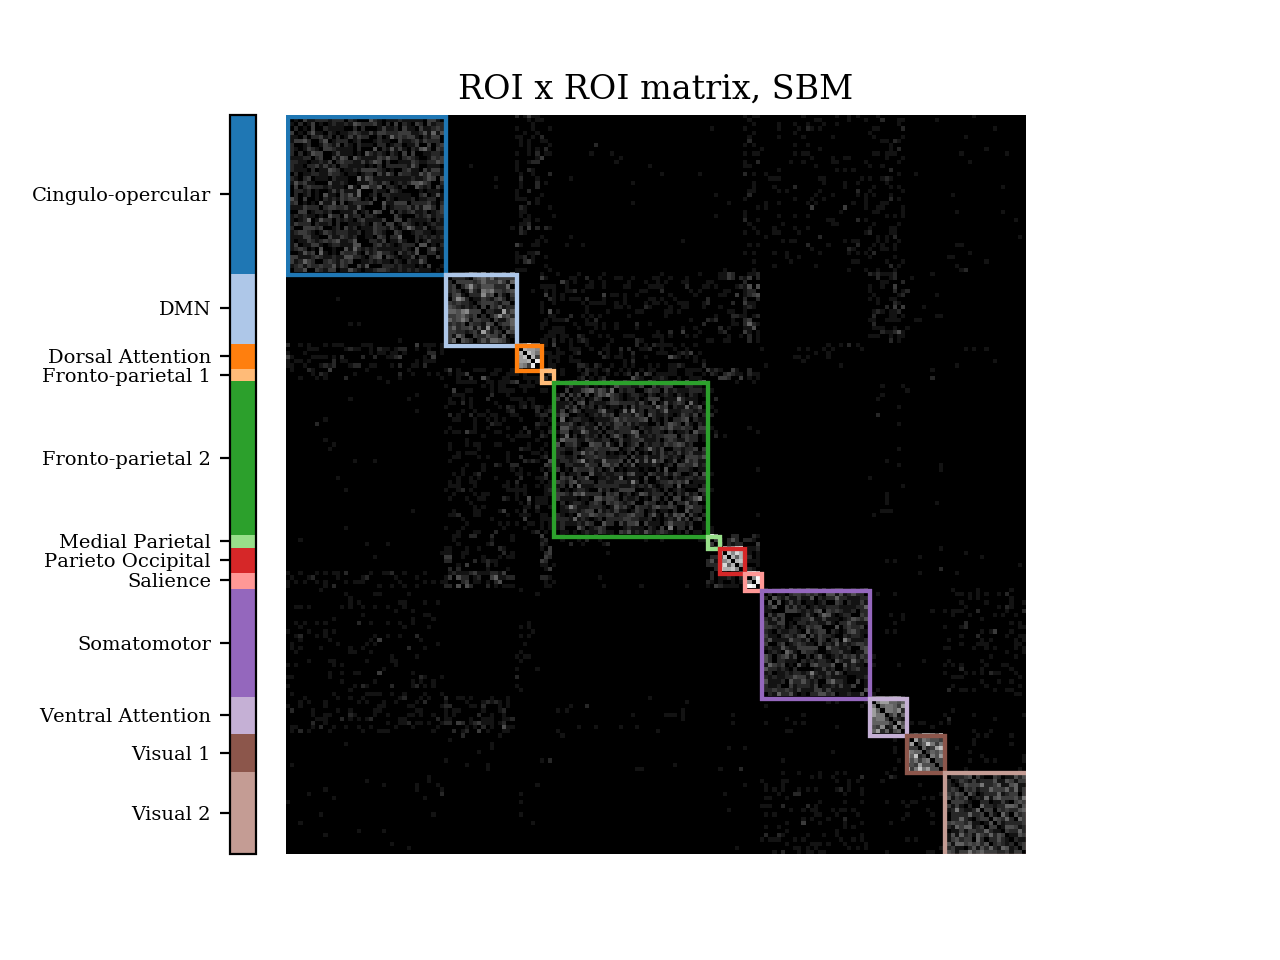

In [136]:
sbm.run()
sbm.plot()
plt.savefig('figures/sbm_ram.png', dpi=300)

<IPython.core.display.Javascript object>


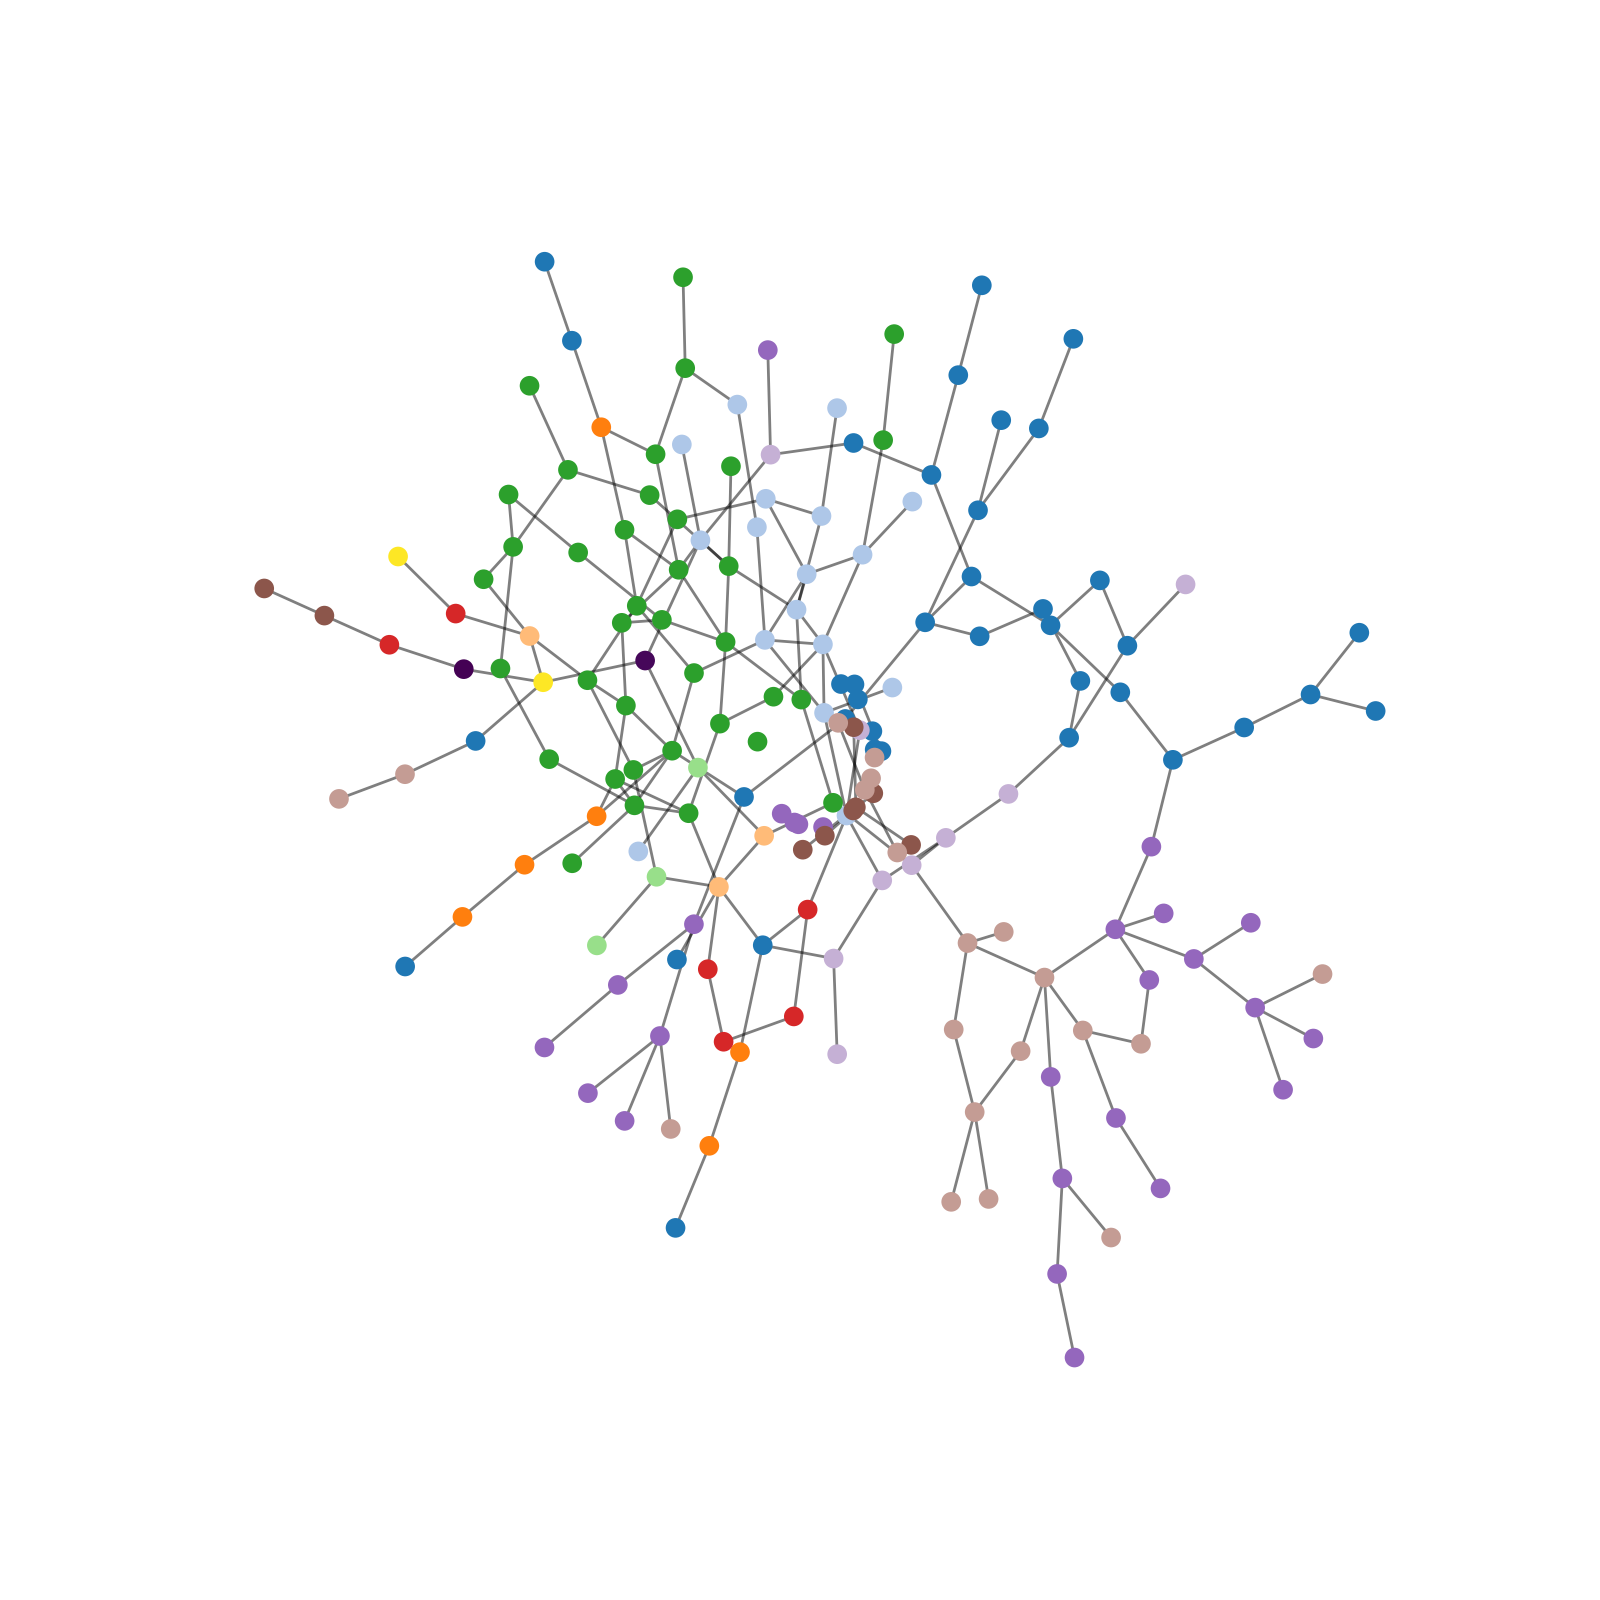

In [142]:
plt.close('all')
# Generate colormap
cmap = mpl.cm.get_cmap('tab20', 20)
colors = cmap(np.linspace(0,1,20))

pos = nx.kamada_kawai_layout(sbm.G_,scale=0.5)
for com in set(sbm.partition.values()) :
    list_nodes = [nodes for nodes in sbm.partition.keys() if sbm.partition[nodes] == com]
    nx.draw_networkx_nodes(sbm.G_, pos, list_nodes, node_size = 50, node_color = colors[com], edgecolors = 'none')

nx.draw_networkx_edges(sbm.G_, pos, alpha=0.5)
ax = plt.gca()
ax.axis('off')
fig = plt.gcf()
fig.set_size_inches(8,8)

plt.savefig('figures/sbm_super.png', dpi=300)

<IPython.core.display.Javascript object>


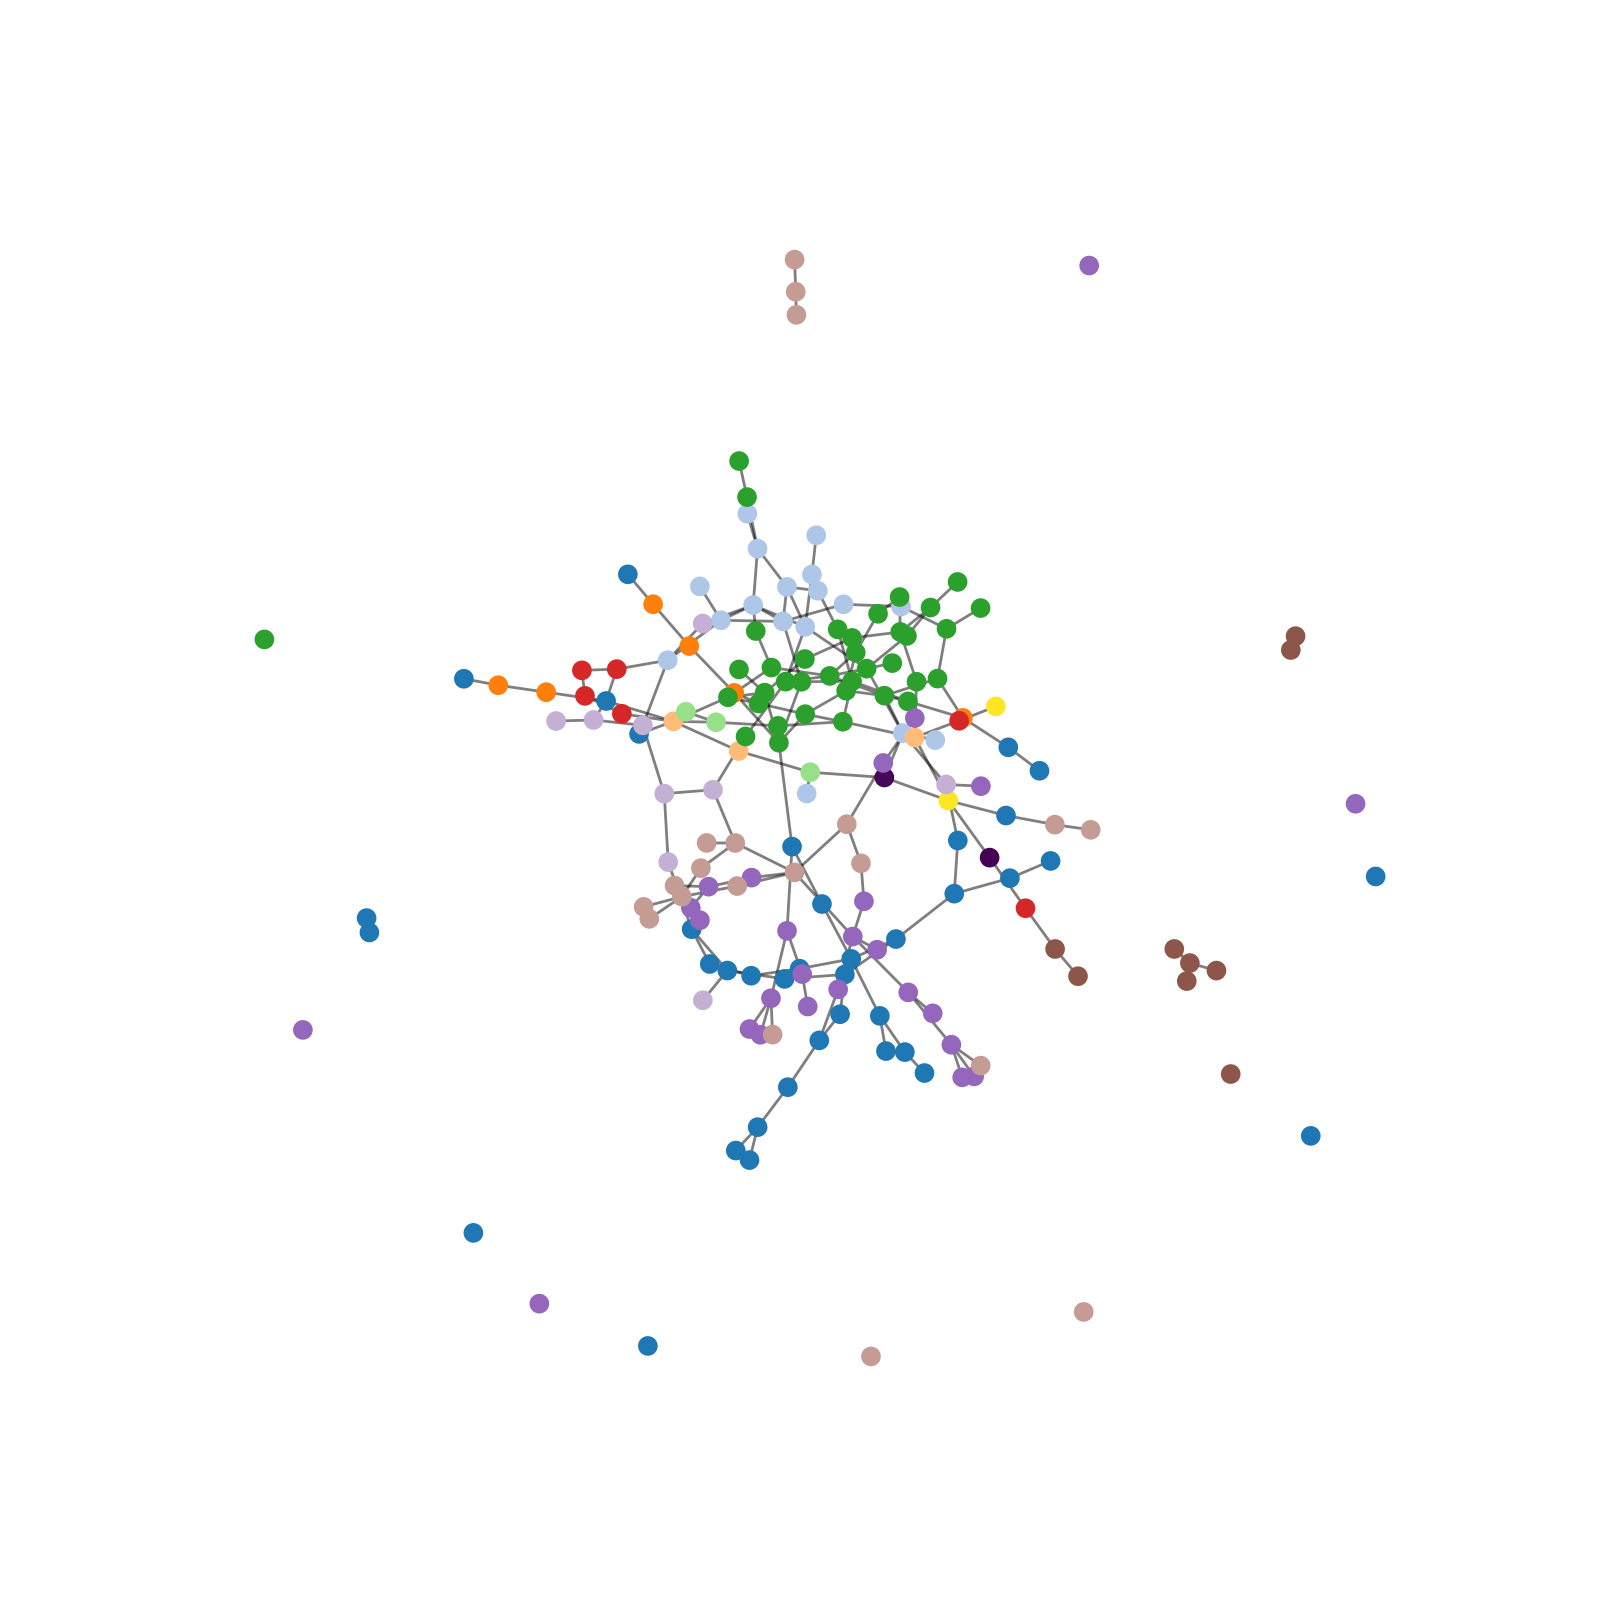

In [141]:
sbm.draw()
plt.savefig('figures/sbm_super2.png',dpi=300)